In [1]:
import pathlib
import os
import random
import copy
import re
from tqdm import tqdm, trange
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import math

import scipy 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sklearn
import nibabel as nib
import imblearn
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

ModuleNotFoundError: No module named 'imblearn'

# Raw Data 

153 patients have T1/T2/FLAIR


2 patients have T1/T2 Missing FLAIR


32 patients have T2/FLAIR Missing T1


79 SPMS, 69 Stable, 39 Worsening


# Data Preprocessed strategy

If FLAIR is missing then T2 will be duplicate.


If T1 is missing then T2 will be duplicate.

Min Max normalization were done by patients (not done by slices)

# Data Split strategy

60% training, 20% validation, 20% testing


In [7]:
from re import sub
from unittest import result


def get_file_path(root:str):
    spms, stable, worsening = [],[],[]
    paths, split_path = [],[]
    for i in list(pathlib.Path(root).glob('*/')):
        splited_filename = re.split(r'[\_\.]+', str(i))
        if 'nii' in splited_filename and 'gz' in splited_filename:
            split_path.append(splited_filename) 
            paths.append(str(i))
    spms = find_same_seq(paths, split_path, "SPMS", 0)
    stable = find_same_seq(paths, split_path, "stable", 1)
    worsening = find_same_seq(paths, split_path, "worsening", 2)

    return spms, stable, worsening

def find_same_seq(paths, split_path, class_name, label):
    TTF,T1T2, T2F, same_class, result= [],[],[],[],[]
    for index, value in enumerate(split_path):
        if class_name in value:
            same_class.append([paths[index], value])
    for i in same_class:
        if 'T1' in i[1] and 'T2' in i[1] and 'FLAIR' in i[1]:
            TTF.append(i[0])
        elif 'T1' in i[1] and 'T2' in i[1] and 'FLAIR' not in i[1]:
            T1T2.append(i[0])
        elif 'T1' not in i[1] and 'T2' in i[1] and 'FLAIR' in i[1]:
            T2F.append(i[0])
    for i in [TTF, T1T2, T2F]:
        if len(i) != 0:
            result.append(i)
    result.append(label)
    return result

def concatenate_and_fill(file_paths, slice_range, save_path):
    image = []
    for i in trange(0, len(file_paths)-1):
        lbl = file_paths[-1]
        splited_filename = re.split(r'[\_\.]+', str(file_paths[i]))
        t1,t2,flair = [], [], []
        print(file_paths[i])

        if 'T1' in splited_filename and 'T2' in splited_filename and 'FLAIR' in splited_filename:
            t1 = nib.load(file_paths[i][1]).get_fdata().astype("float16").swapaxes(0,3).swapaxes(1,2)
            t2 = nib.load(file_paths[i][2]).get_fdata().astype("float16").swapaxes(0,3).swapaxes(1,2)
            flair = nib.load(file_paths[i][0]).get_fdata().astype("float16").swapaxes(0,3).swapaxes(1,2)

        elif 'T1' in splited_filename and 'T2' in splited_filename and 'FLAIR' not in splited_filename:
            continue
            t1 = nib.load(file_paths[i][0]).get_fdata().astype("float16")
            t2 = nib.load(file_paths[i][1]).get_fdata().astype("float16")
            if len(t1.shape) < 4: 
                t1 = t1[:,:,:,np.newaxis].swapaxes(0,3).swapaxes(1,2)
                t2 = t2[:,:,:,np.newaxis].swapaxes(0,3).swapaxes(1,2)
            else:
                t1 = nib.load(file_paths[i][0]).get_fdata().astype("float16").swapaxes(0,3).swapaxes(1,2)
                t2 = nib.load(file_paths[i][1]).get_fdata().astype("float16").swapaxes(0,3).swapaxes(1,2)
            flair = t2

        elif 'T1' not in splited_filename and 'T2' in splited_filename and 'FLAIR' in splited_filename:
            continue
            t1 = nib.load(file_paths[i][1]).get_fdata().astype("float16").swapaxes(0,3).swapaxes(1,2)
            t2 = t1
            flair = nib.load(file_paths[i][0]).get_fdata().astype("float16").swapaxes(0,3).swapaxes(1,2)

        t1 = min_max_normalize(t1[:,slice_range[0]:slice_range[1],np.newaxis, :,:])
        t2 = min_max_normalize(t2[:,slice_range[0]:slice_range[1],np.newaxis, :,:])
        flair = min_max_normalize(flair[:,slice_range[0]:slice_range[1],np.newaxis, :,:])
        concatenated_result = np.concatenate((t1,t2,flair),axis=2)
        print(concatenated_result.shape, t1.shape, t2.shape, flair.shape)
        print(np.min(concatenated_result), np.max(concatenated_result))
        for j in concatenated_result:
            image.append(j)

    print(np.array(image).shape)
    np.save(save_path+'_img.npy', image)


def min_max_normalize(input_array):
    for (subject_ind, subjects) in enumerate(input_array):
        for (slice_ind, slices) in enumerate(subjects):
            minimum = np.min(slices)
            maximum = np.max(slices)
            if maximum == minimum: 
                continue
            input_array[subject_ind][slice_ind] = (slices - minimum)/(maximum-minimum)
    return input_array


In [8]:
slice_range = [30, 125]    
spms, stable, worsening = get_file_path("")
concatenate_and_fill(spms, slice_range, '..\..\..\data\preprocessed_data\SPMS_3Classes_187patients\spms')
concatenate_and_fill(stable, slice_range, '..\..\..\data\preprocessed_data\SPMS_3Classes_187patients\stable')
concatenate_and_fill(worsening, slice_range, '..\..\..\data\preprocessed_data\SPMS_3Classes_187patients\worsening')

  0%|          | 0/3 [00:00<?, ?it/s]

['RRMS_SPMS_T1_T2_FLAIR_FLAIRreg.nii.gz', 'RRMS_SPMS_T1_T2_FLAIR_T1reg.nii.gz', 'RRMS_SPMS_T1_T2_FLAIR_T2reg.nii.gz']
(65, 95, 3, 256, 256) (65, 95, 1, 256, 256) (65, 95, 1, 256, 256) (65, 95, 1, 256, 256)


100%|██████████| 3/3 [01:09<00:00, 23.21s/it]

0.0 1.0
['RRMS_SPMS_T1_T2_T1reg.nii.gz', 'RRMS_SPMS_T1_T2_T2reg.nii.gz']
['RRMS_SPMS_T2_FLAIR_FLAIRreg.nii.gz', 'RRMS_SPMS_T2_FLAIR_T2reg.nii.gz']


(65, 95, 3, 256, 256)


  0%|          | 0/2 [00:00<?, ?it/s]

['RRMS_stable_T1_T2_FLAIR_FLAIRreg.nii.gz', 'RRMS_stable_T1_T2_FLAIR_T1reg.nii.gz', 'RRMS_stable_T1_T2_FLAIR_T2reg.nii.gz']
(57, 95, 3, 256, 256) (57, 95, 1, 256, 256) (57, 95, 1, 256, 256) (57, 95, 1, 256, 256)


100%|██████████| 2/2 [00:51<00:00, 25.61s/it]

0.0 1.0
['RRMS_stable_T2_FLAIR_FLAIRreg.nii.gz', 'RRMS_stable_T2_FLAIR_T2reg.nii.gz']


(57, 95, 3, 256, 256)


  0%|          | 0/3 [00:00<?, ?it/s]

['RRMS_worsening_T1_T2_FLAIR_FLAIRreg.nii.gz', 'RRMS_worsening_T1_T2_FLAIR_T1reg.nii.gz', 'RRMS_worsening_T1_T2_FLAIR_T2reg.nii.gz']
(31, 95, 3, 256, 256) (31, 95, 1, 256, 256) (31, 95, 1, 256, 256) (31, 95, 1, 256, 256)


100%|██████████| 3/3 [00:26<00:00,  8.82s/it]

0.0 1.0
['RRMS_worsening_T1_T2_T1reg.nii.gz', 'RRMS_worsening_T1_T2_T2reg.nii.gz']
['RRMS_worsening_T2_FLAIR_FLAIRreg.nii.gz', 'RRMS_worsening_T2_FLAIR_T2reg.nii.gz']


(31, 95, 3, 256, 256)


# Split dataset

In [9]:
def patients_index(total_patients, ratio):
    result = []
    for i in total_patients:
        temp = [math.floor(i*ratio[0]), math.floor(i*ratio[1]), math.floor(i*ratio[2])]
        while sum(temp) != i:
            temp[0]+=1
        temp[1] = temp[0] + temp[1]
        temp[2] = temp[1] + temp[2]
        result.append(temp)
    return result

def construct_dataset(patients_index, file_path, save_path):

    class0 = np.load(file_path[0])
    np.random.shuffle(class0 )
    class1 = np.load(file_path[1])
    np.random.shuffle(class1)
    class2 = np.load(file_path[2])
    np.random.shuffle(class2)
    num_slices_per_patient = class0.shape[1]
    train = np.concatenate((class0[0:patients_index[0][0]], class1[0:patients_index[1][0]], class2[0:patients_index[2][0]]), axis=0)
    val = np.concatenate((class0[patients_index[0][0]:patients_index[0][1]], class1[patients_index[1][0]:patients_index[1][1]], class2[patients_index[2][0]:patients_index[2][1]]), axis=0)
    test = np.concatenate((class0[patients_index[0][1]:patients_index[0][2]], class1[patients_index[1][1]:patients_index[1][2]], class2[patients_index[2][1]:patients_index[2][2]]), axis=0)



    train = np.reshape(train, (train.shape[0]*train.shape[1], train.shape[2], train.shape[3], train.shape[4]))
    test = np.reshape(test, (test.shape[0]*test.shape[1], test.shape[2], test.shape[3], test.shape[4]))
    val = np.reshape(val, (val.shape[0]*val.shape[1], val.shape[2], val.shape[3], val.shape[4]))
    print(train.shape, test.shape, val.shape)

    np.save(save_path+'training_img.npy', train)
    np.save(save_path+'testing_img.npy', test)
    np.save(save_path+'validation_img.npy', val)

    np.save(save_path+'training_lbl.npy', np.concatenate((np.array([0]*((patients_index[0][0])*num_slices_per_patient)), np.array([1]*((patients_index[1][0])*num_slices_per_patient)), np.array([2]*((patients_index[2][0])*num_slices_per_patient)))))
    np.save(save_path+'testing_lbl.npy', np.concatenate((np.array([0]*((patients_index[0][1]-patients_index[0][0])*num_slices_per_patient)), np.array([1]*((patients_index[1][1]-patients_index[1][0])*num_slices_per_patient)), np.array([2]*((patients_index[2][1]-patients_index[2][0])*num_slices_per_patient)))))
    np.save(save_path+'validation_lbl.npy', np.concatenate((np.array([0]*((patients_index[0][2]-patients_index[0][1])*num_slices_per_patient)), np.array([1]*((patients_index[1][2]-patients_index[1][1])*num_slices_per_patient)), np.array([2]*((patients_index[2][2]-patients_index[2][1])*num_slices_per_patient)))))


In [10]:
num_subjects = [65,57,31]
ratio = [0.6, 0.2, 0.2]
file_paths = ['../../../data/preprocessed_data/SPMS_3Classes_187patients/spms_img.npy', '../../../data/preprocessed_data/SPMS_3Classes_187patients/stable_img.npy', '../../../data/preprocessed_data/SPMS_3Classes_187patients/worsening_img.npy']
saving_path = '../../../data/preprocessed_data/SPMS_3Classes_187patients/'
patients_index_per_set = patients_index(num_subjects, ratio)
construct_dataset(patients_index_per_set, file_paths, saving_path)

(8835, 3, 256, 256) (2850, 3, 256, 256) (2850, 3, 256, 256)


# Upsampling dataset

In [ ]:
def resampling(imgs, lbls, transforms, type='SMOTE' ):
    raw_imgs = imgs
    raw_labels = lbls

    # get all the images and labels out form the input dataset
    # for index,(img, lab) in enumerate(dataset):
    #     raw_imgs.append(img.numpy())
    #     raw_labels.append(lab)
    print(raw_imgs[0].dtype, raw_imgs[0].shape)
    height = raw_imgs[0].shape[1]
    width = raw_imgs[0].shape[2]
    channel = raw_imgs[0].shape[0]
    # change the data type from original list to numpy array
    raw_imgs = np.array(raw_imgs)
    raw_labels = np.array(raw_labels)

    # resize the image form 4D array(total num of samples, C, W, H ) to 2d array(total num of samples, C*H*W) 
    raw_imgs = np.reshape(raw_imgs, (raw_imgs.shape[0], height*width*channel))

    # Define the SMOTE alg, SMOTE can be change to other varients of SMOTE
    s = 0
    if (type == 'SMOTE'):
        print("SMOTE")
        s = imblearn.over_sampling.SMOTE(random_state=42)
    elif(type == 'board_smote'):
        print("board_smote")
        s = imblearn.over_sampling.BorderlineSMOTE(random_state=42)
    elif(type == 'ADASYNC'):
        print("ADASYNC")
        s = imblearn.over_sampling.ADASYN(random_state=42)
    elif(type == 'SVM'):
        print("SVM")
        s = imblearn.over_sampling.SVMSMOTE(random_state=42)
    elif(type == 'SMOTEENN'):
        print("SMOTEENN")
        s = imblearn.combine.SMOTEENN(random_state=42)
    elif(type == "SMOTETomek"):
        print("SMOTETomek")
        s = imblearn.combine.SMOTETomek(random_state = 42)
    resampled_img, resampled_lbl = s.fit_resample(raw_imgs, raw_labels)
    # resize the output of samples form (total num of samples, C*H*W) to (total num of samples, C, W, H )
    resampled_img = resampled_img.reshape((resampled_img.shape[0], channel,height,width))
    return Resampled_dataset(resampled_img, resampled_lbl, transforms)

# Validation 

In [ ]:
readin = np.load("D:/allWorkingSpaces/ViT_Classification/data/preprocessed_data/SPMS_3Classes_187patients/testing_img.npy").astype("float16")
readin2 = np.load("D:/allWorkingSpaces/ViT_Classification/data/preprocessed_data/SPMS_3Classes_187patients/worsening_lbl.npy").astype("float16")
print(readin.shape)
print(readin)
# print(np.reshape(readin,(6084,3,256,256)).shape, readin2.shape)


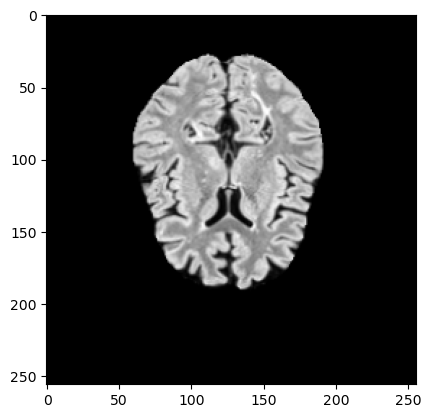

In [30]:
plt.imshow(np.reshape(readin,(3325,3,256,256))[50][2], cmap="grey")


normalization, min max method to change the range form 0-1.
Try CNN.
z-scored normalization 